## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib qt

#Visualise detected checkerboard corners
visualise = False

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if visualise:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
def compare_images(img_org, img_undist):
    # Visualize distortion corrected image as compared to original
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    if len(img_undist.shape) == 2:
        ax1.imshow(img_org, cmap='gray')
    else:
        ax1.imshow(img_org)
    ax1.axis('off')
    ax1.set_title('Image Before', fontsize=30)
    if len(img_undist.shape) == 2:
        ax2.imshow(img_undist, cmap='gray')
    else:
        ax2.imshow(img_undist)
    ax2.set_title('Image After', fontsize=30)
    ax2.axis('off')

In [3]:
def import_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

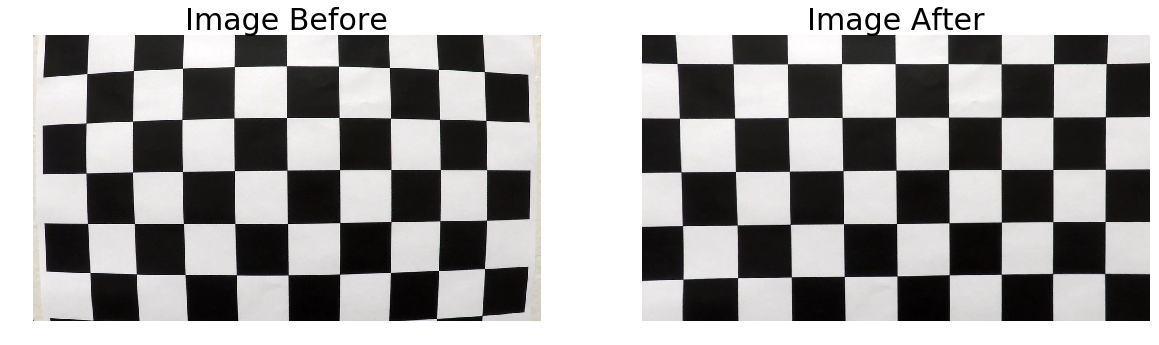

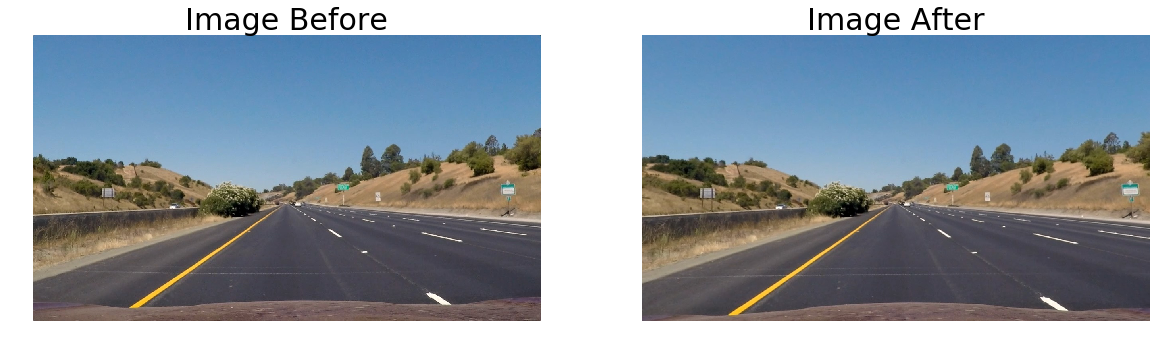

In [4]:
%matplotlib inline

# Camera calibration 
img = import_image('./camera_cal/calibration1.jpg')
img_res = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_res,None,None)
distortion_obj = {"mtx": mtx, "dist": dist}

# Test images:
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

img = import_image('./test_images/straight_lines1.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

## Perspective Transform

In [5]:
def perspective_transform(img):
    # Tune source points to ensure that lane lines run 
    # vertically for a straight piece of road.
    
    src_top_left  = [0.45 * img_res[0], 0.624 * img_res[1]]
    src_top_right = [0.55 * img_res[0], 0.624 * img_res[1]]
    src_bot_left  = [0.00 * img_res[0], 0.95 * img_res[1]]
    src_bot_right = [1.00 * img_res[0], 0.95 * img_res[1]]

    dst_top_left  = [0 * img_res[0], 0 * img_res[1]]
    dst_top_right = [1 * img_res[0], 0 * img_res[1]]
    dst_bot_left  = [0 * img_res[0], 1 * img_res[1]]
    dst_bot_right = [1 * img_res[0], 1 * img_res[1]]
    
    src = np.float32([src_top_left
                     ,src_top_right
                     ,src_bot_left
                     ,src_bot_right])

    dst = np.float32([dst_top_left
                     ,dst_top_right
                     ,dst_bot_left
                     ,dst_bot_right])

    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(udist, perspective_matrix, img_res)

True

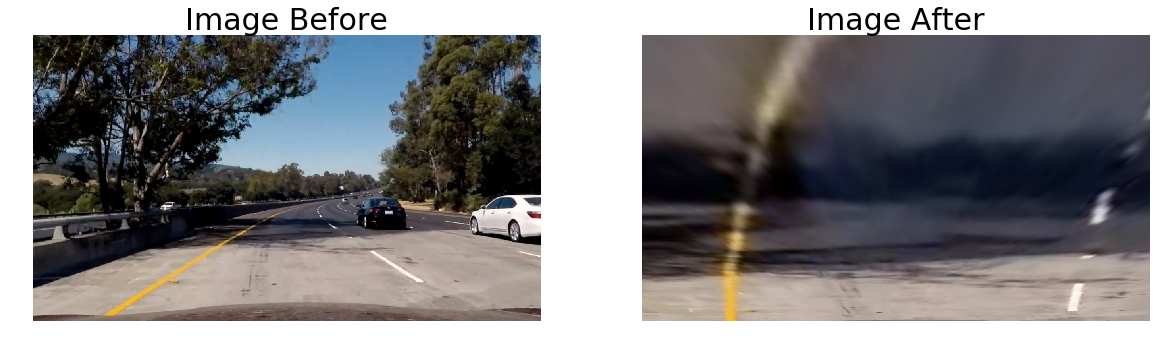

In [102]:
img = import_image('./test_images/test5.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_transform(udist)
compare_images(udist, warped)
cv2.imwrite('./output_images/test_perspective.jpg',warped)

## Thresholded binary image

In [103]:
def hls_select(img, threshold=137):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > threshold)] = 1
    return binary_output

In [104]:
def plotColourChannels(image, colorspace="RGB"):
    
    print('Note: Input image must be in RGB color space!')
    
    if not colorspace == 'RGB':
        converter = getattr(cv2, "COLOR_RGB2" + colorspace)
        converted_img = cv2.cvtColor(image, converter)
    else:
        converted_img = image
        
    color_channel_names = {'RGB': ['Red', 'Green', 'Blue']
                          ,'BGR': ['Blue', 'Green', 'Red']
                          ,'HLS': ['Hue', 'Lightness', 'Saturation']
                          ,'HSV': ['Hue', 'Saturation', 'Value']}
    
    assert colorspace in color_channel_names, 'The chosen colorspace does not appear in our list [RGB, BGR, HLS, HSV].'
    
    plt.subplots(2, 2, figsize=(20,12))
    
    for i in range(1,5):
        plt.subplot(2, 2, i)
        if i==1:
            plt.imshow(image)
            title = 'Original Image'
        else:
            plt.imshow(converted_img[:,:,i-2], cmap='gray')
            title = color_channel_names[colorspace][i-2] + ' Channel'
        plt.axis('off')
        plt.title(title, fontsize=30)

Note: Input image must be in RGB color space!


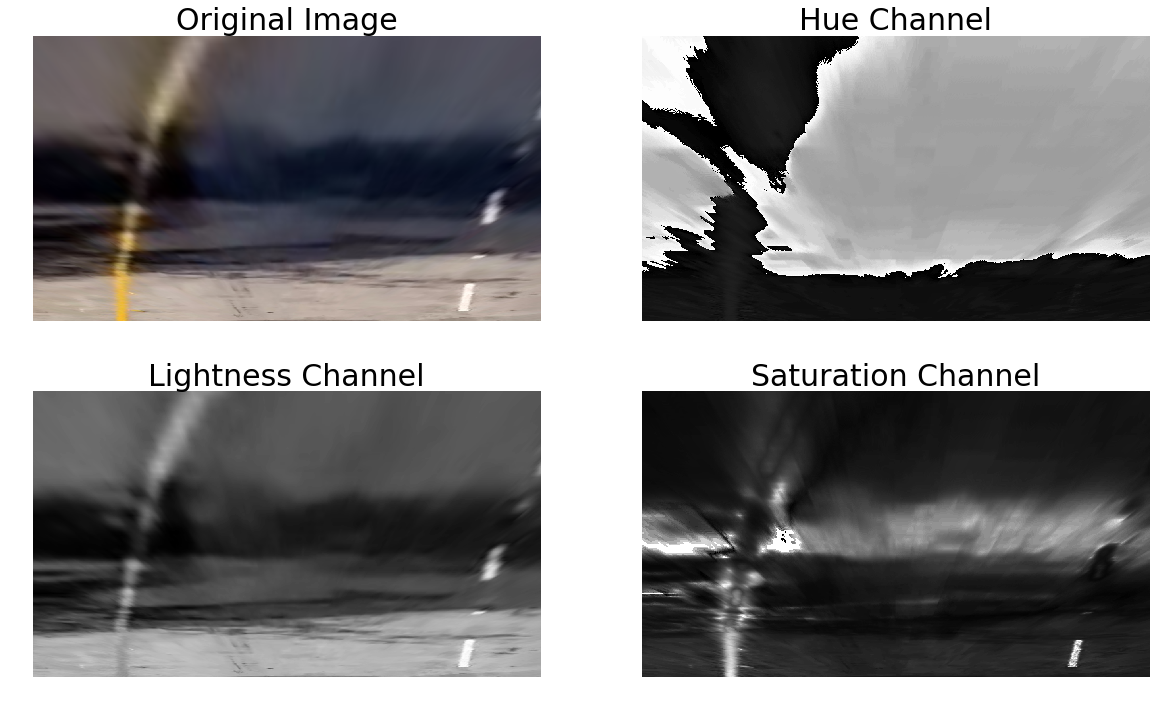

In [105]:
# Plot the result
plotColourChannels(warped, colorspace='HLS')

In [106]:
def adaptive_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    return cv2.adaptiveThreshold(channel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,251,-16)

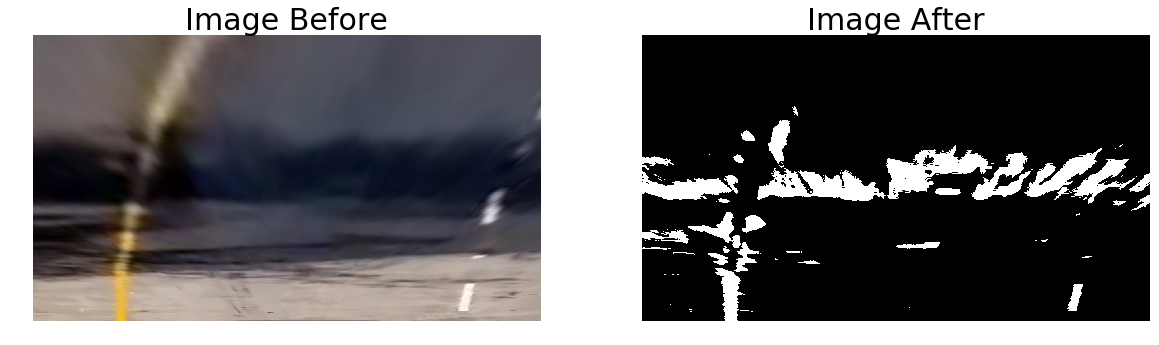

In [107]:
threshold_img = adaptive_threshold(warped)
compare_images(warped, threshold_img)

In [108]:
def translate_horz(img, direction='left', shift=0.01):
    img_res = img.shape

    src_top_left  = [0 * img_res[1], 0 * img_res[0]]
    src_top_right = [1 * img_res[1], 0 * img_res[0]]
    src_bot_left  = [0 * img_res[1], 1 * img_res[0]]
    src_bot_right = [1 * img_res[1], 1 * img_res[0]]
    
    if direction is 'right':
        shift = -shift
        
    dst_top_left  = [(0 + shift) * img_res[1], 0 * img_res[0]]
    dst_top_right = [(1 + shift) * img_res[1], 0 * img_res[0]]
    dst_bot_left  = [(0 + shift) * img_res[1], 1 * img_res[0]]
    dst_bot_right = [(1 + shift) * img_res[1], 1 * img_res[0]]
    
    src = np.float32([src_top_left
                     ,src_top_right
                     ,src_bot_left
                     ,src_bot_right])

    dst = np.float32([dst_top_left
                     ,dst_top_right
                     ,dst_bot_left
                     ,dst_bot_right])
    
    transform = cv2.getPerspectiveTransform(src, dst)

    return cv2.warpPerspective(img, transform, (img_res[1], img_res[0]))

In [109]:
def abs_sobel_thresh(img, orient='x', thresh_min=0):
    gray = img[:,:,0]

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = translate_horz(scaled_sobel, direction='left', shift=0.01)/2
    binary_output = binary_output + translate_horz(scaled_sobel, direction='right', shift=0.01)/2
    
    
    binary_output = np.where(binary_output > thresh_min, binary_output*1, 0)
    
    print(np.max(binary_output))
    return binary_output

232.5


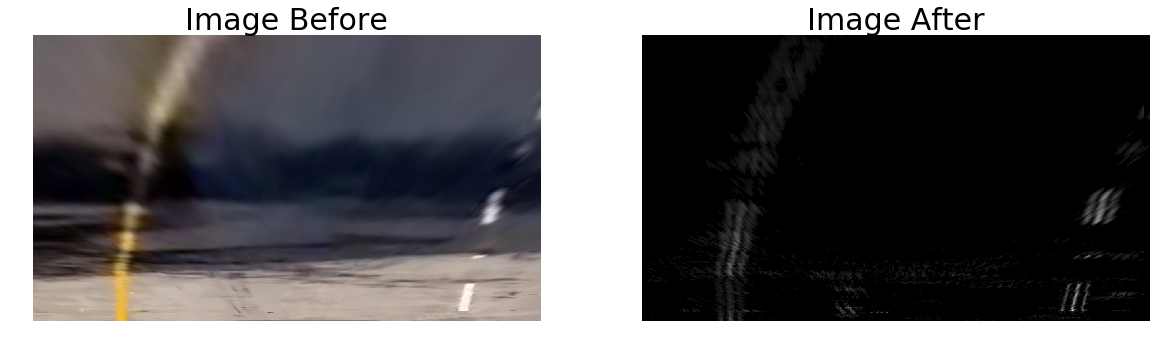

In [110]:
# Run the function
grad_binary = abs_sobel_thresh(warped, orient='x', thresh_min=10)
compare_images(warped, grad_binary)

In [111]:
def combine_images(img1, img2, method="Add"):
    
    possible_methods = ['Add', 'Subtract']
    
    assert method.lower() in [x.lower() for x in possible_methods], \
        'The supplied combination method is not recognised.'
    
    img1 = np.array(img1, dtype=np.float32)
    img2 = np.array(img2, dtype=np.float32)
    
    if method.lower() == 'add':
        #return np.where(img2 + img1 > 255, 255, img1 + img2)
        return img1 + img2
    elif method.lower() == 'subtract':
        img2 = np.where(img2 > img1, img1, img2)
        return img1 - img2 #_t - img1
    else:
        print('Error: the supplied method is not recognised.')


232.5


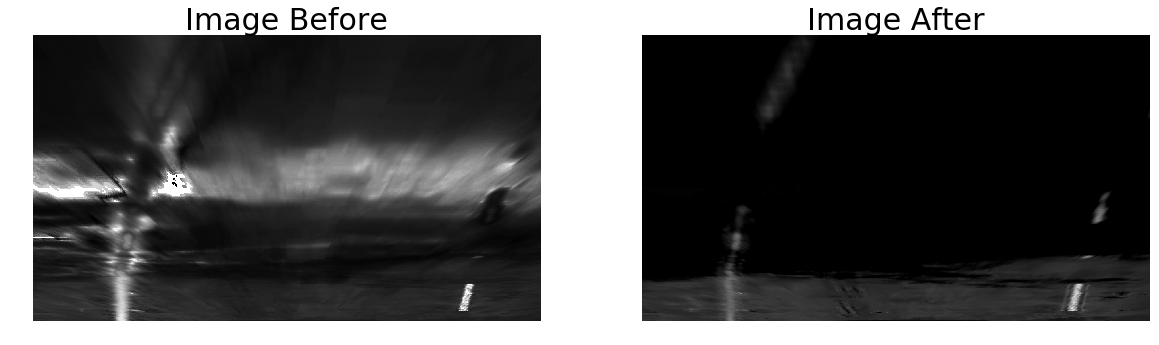

In [112]:
# Calculate saturation threshold
hls_img = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
saturation_channel = hls_img[:,:,2]
lightness_channel = hls_img[:,:,1]
darkness_channel = (255-lightness_channel)
sobel_grad_red = abs_sobel_thresh(warped, orient='x', thresh_min=10)

sum_img = combine_images(sobel_grad_red, saturation_channel, method='add') 
sum_img = combine_images(sum_img, lightness_channel, method='add') 
sum_img = combine_images(sum_img, darkness_channel, method='subtract') 

norm_img = np.zeros(sum_img.shape)
norm_img = cv2.normalize(sum_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

compare_images(saturation_channel, norm_img)

## Detect Lane Lines

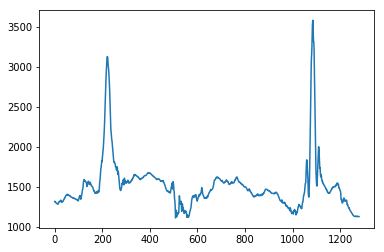

In [114]:
def hist(img):
    bottom_half = img[680:710,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(norm_img)

plt.plot(histogram)

In [97]:
norm_img.shape

(720, 1280)

## Get Curvature and Car Position

## Original Perspective

## Visual Output